<a href="https://colab.research.google.com/github/cmiglio/signal_processing_with_python/blob/master/signal_processing_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal analysis with python

*Carolina Migliorelli*


The purpose of this workshop is to show an example on how to work with Python with signals. 
We will give some general ideas on how to **read, process and visualize data**

We will use some common python toolboxes: 
* [numpy](https://numpy.org/): It contains the main functions to work with matrices (very similar to Matlab)
* [pandas](https://pandas.pydata.org/): A way of organizing the data
* [seaborn](https://seaborn.pydata.org/): A visualization library with nice plots (that use in its backgroud [matplotlib](https://matplotlib.org/).
* [scipy](https://www.scipy.org/): We will use scipy to load mat files.
* [mne](https://mne.tools/stable/index.html): A package for analyzing human neurophysiological data

For this workshop, we will load data from one epileptic patient and we will extract some events of interest. We will plot the time-frequency representation of these events using the stockwell transform and we will save into a dataframe structure (a table) some meaningful features.

## 0. Installing packages
If you don't have installed the toolboxes, then you should install them. 

In [ ]:
!pip install numpy pandas seaborn scipy mne
!git clone https://github.com/cmiglio/signal_processing_with_python.git

     |████████████████████████████████| 6.4MB 3.4MB/s 
Cloning into 'signal_processing_with_python'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


## 1. Importing packages 
We will start importing the packages. When we use *import* we import the whole package, with the name that we put after *as*. If we don't want to import the whole package but only some functions, we can use *from*. 

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
import mne
from mne.time_frequency import (tfr_array_stockwell) 
from matplotlib import pyplot as plt

## 2. Loading the data
### 2.1. Loading the data using loadmat (from scipy)
We will load the data that, in this case, is stored in a *.mat* file. We can import data with other formats using MNE ([see here](https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#sphx-glr-auto-tutorials-io-plot-20-reading-eeg-data-py)). But however, .TRC (micromed) files are not currently included in MNE distribution, so what I did is reading the data with matlab and then save it into a .mat file. If you are interested in knowing how to create the .mat file, I cand send you my routines. 

In [52]:
# Files were saved into a structure, you should know the names of each field
# in the structure. If not, you can check de names usign structure.keys().
# The squeeze_me parameter must be set to True.
structure = loadmat('signals.mat',squeeze_me=True)
data = structure['data']
sfreq = structure['sfreq']
ch_names = structure['ch_names']
ch_types = structure['ch_types']
differential = structure['differential']
average = structure['average']
needle_names = structure['needle_names']
needle = structure['needle1']
pos = structure['pos']

### 2.2. Creating an mne raw array
To work with MNE (and use filters for example), we have to create a data structure that MNE understands.  

In [53]:
# We have to change the numpy arrays to lists
info = mne.create_info(ch_names=ch_names.tolist(), sfreq=sfreq, ch_types=ch_types.tolist())
raw = mne.io.RawArray(data, info)

ValueError: Data must be a 2D array of shape (n_channels, n_samples), got shape (21,)

## 3. Processing data
### 3.1. Filtering with MNE
We will filter the data above 80 Hz and we will notch the data to remove the line noise (50Hz and the harmonics)

In [9]:
raw.notch_filter([50, 100, 150, 200, 250], fir_design='firwin',verbose=False)
raw80 = raw.copy() # We create a copy of our data
raw80.filter(80,None,fir_design='firwin',verbose=False)

<RawArray  |  None, n_channels x n_times : 20 x 61440 (60.0 sec), ~9.4 MB, data loaded>

### 3.2. Obtaining the envelope of the signal and computing the threshold
We want to obtain the envelope of the signal using hilbert and to obtain the events that are higher than a threshold. We will set the threshold to:
``` python
mean + 3*sd.
```
(Other more sophisticated methods to obtain the threshold could be applyied)


We will compute this only for one channel, but I leave you the code to compute this for all the channels (using for in python is easy, but a little bit different than in Matlab)


The code to iterate trough channels is: 
```python

# We obtain a vector that have the size of the channels and other vector with 
# the same size for the threshold
channels_vector = np.arange(0,len(raw80.ch_names)) 
th = np.zeros(channels_vector.shape) 

for chan_n in channels_vector: # We iterate trough the channels
    data_80 = raw80.get_data(picks=chan_n) # We obtain the data for one channel
    data_hil = np.abs(raw_hilb.get_data(picks=chan_n)) # We obtain the envelope for one channel
    th[chan_n] = np.mean(data_hil) + 3*np.std(data_hil)
    
    # All this code is to detect events of interest that will be saved into eoi
    # Where function is similar to find
    change = np.diff((data_hil[0,:]>th[chan_n])*1)
    if change[np.where(change)[0][0]]==-1:
        change[np.where(change)[0][0]]=0
    ch_pos=np.sum(change==1)
    ch_neg=np.sum(change==-1)
    if ch_pos>ch_neg:
        # Si hay 1 positivo mas que negativo, entonces es que hemos acabado encima del threshold--> descartamos el ultimo positivo
        p_aux_ini=np.where(change==1)[0][:-2]
        p_aux_fin=np.where(change==-1)[0]
    elif ch_pos<ch_neg:
        # Si hay 1 negativo más que un positivo, entonces es que he empezado encima del threshold--> descartamos el primer negativo
        p_aux_ini=np.where(change==1)[0]
        p_aux_fin=np.where(change==-1)[0][1:]
    elif ch_pos==ch_neg:
        p_aux_ini=np.where(change==1)[0]
        p_aux_fin=np.where(change==-1)[0]
    eoi = np.array(list(zip(p_aux_ini,p_aux_fin)))
```

In [40]:
raw_hilb = raw80.copy() # We create a copy of our filtered data
raw_hilb.apply_hilbert() # We apply hilbert to obtain the envelope

chan_n = 10 # We will compute this for the first channel (in python the first index is 0)

data = raw.get_data(picks=chan_n)
data80 = raw80.get_data(picks=chan_n)
data_hil = np.abs(raw_hilb.get_data(picks=chan_n))
th = np.mean(data_hil) + 3*np.std(data_hil)
change = np.diff((data_hil[0,:]>th)*1)
if change[np.where(change)[0][0]]==-1:
    change[np.where(change)[0][0]]=0
ch_pos=np.sum(change==1)
ch_neg=np.sum(change==-1)
if ch_pos>ch_neg:
            # Si hay 1 positivo mas que negativo, entonces es que hemos acabado encima del threshold--> descartamos el ultimo positivo
    p_aux_ini=np.where(change==1)[0][:-2]
    p_aux_fin=np.where(change==-1)[0]
elif ch_pos<ch_neg:
     # Si hay 1 negativo más que un positivo, entonces es que he empezado encima del threshold--> descartamos el primer negativo
    p_aux_ini=np.where(change==1)[0]
    p_aux_fin=np.where(change==-1)[0][1:]
elif ch_pos==ch_neg:
    p_aux_ini=np.where(change==1)[0]
    p_aux_fin=np.where(change==-1)[0]
eoi = np.array(list(zip(p_aux_ini,p_aux_fin)))


Lets see what we have in *eoi*

In [41]:
print(eoi)

[[23826 23827]
 [23828 23846]
 [23848 23876]
 [23920 23942]
 [23944 23989]
 [24053 24108]
 [24182 24215]
 [24218 24247]
 [30880 30893]
 [30897 30899]
 [31410 31426]
 [50000 50036]
 [50090 50116]]


## 3. Plotting data

We will plot the data of one event using seaborn, we want to plot:
* The raw data
* The filtered data
* The time-frequency distribution computed with stockwell transform

In [45]:
# We select which event we want to plot
event_to_plot = 10 

# We define a window of 500 ms
win_size = int(0.5 * sfreq)
# We create an epoch (the structure needed by mne)
epoch = np.zeros([1,1,win_size*2])
epoch80 = np.zeros([1,1,win_size*2])
epoch_hil = np.zeros([1,1,win_size*2])

mid_event = int((eoi[event_to_plot,0]+ eoi[event_to_plot,1])/2)
epoch[0,0,:] = data[:,mid_event-win_size:mid_event+win_size]
epoch80[0,0,:] = data80[:,mid_event-win_size:mid_event+win_size]
epoch_hil[0,0,:] = data_hil[:,mid_event-win_size:mid_event+win_size]

# We compute stockwell
fmin = 1
fmax = int(sfreq/4)
freqs = np.arange(fmin,fmax)

pwr = tfr_array_stockwell(epoch, fmin=fmin, fmax=fmax, width=3, sfreq=sfreq, n_fft=int(win_size*2));

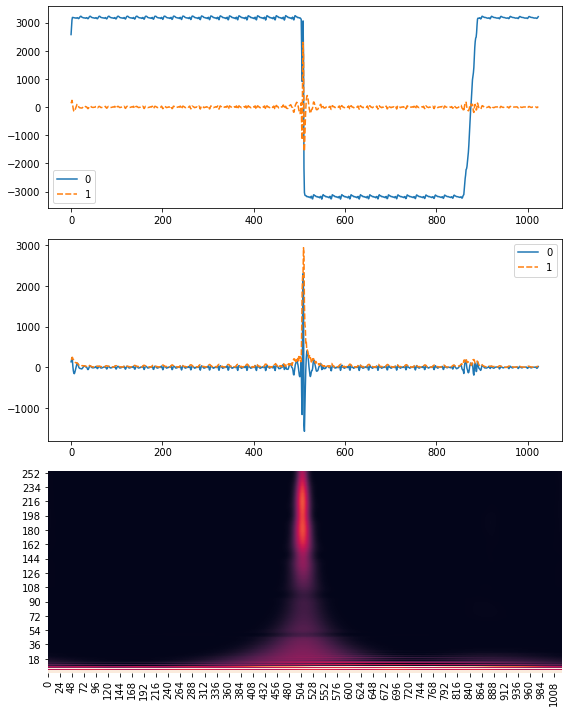

In [48]:
# We plot with seaborn
fig_size = (8, 10)
fig, ax = plt.subplots(3,figsize=fig_size)
plt.autoscale(enable=True, axis='x', tight=True)
sns.lineplot(ax=ax[0],data=[epoch[0,0,:],epoch80[0,0,:]])
sns.lineplot(ax=ax[1],data=[epoch80[0,0,:],epoch_hil[0,0,:]])
sns.heatmap(ax=ax[2],data=pwr[0][0],robust='True',cbar=False)
ax[2].set(ylim=freqs[[0, -1]])
plt.tight_layout()